After importing the necessary libraries and specifying the path to the cross-section data for OpenMC, we proceed with defining the materials. Each material is defined in the cell below, detailed as follows:

1- Fuel: The fuel is composed of U3Si2-Al plates. The uranium content is 62.98% by weight. From this, the weight fraction of Silicon is calculated to be 4.43115% based on the proportionality between Uranium and Silicon. Aluminum serves as a matrix within which U3Si2 is embedded. By subtracting the combined weight fractions of Uranium and Silicon from 100%, the remainder, which is Aluminum, is calculated to be 32.58885% by weight. The enrichment of U-235 is 19.7% by weight, which was averaged from a data of each individual plate in the core collected from reactor history data, and the density of the fuel is 5.55 g/cc. Since U-234 adds more negative reactivity than U-238, it has to be treated carefully, and as U-235 gets enriched, U-234 gets enriched as well at a higher rate, as it is naturally occurring and slightly lighter than U-235. U-234 enrichment was evaluated based on this paper "Estimation of the 234U fraction and uncertainty of enriched and depleted uranium", there is an assumption here which is that the enrichment process was gaseous centrifuge, which is a fair assumption as it is one of the most popular methods of enrichment at the time fuel was provided. 

2- Cladding: Aluminum 6061 (Al6061) is used for cladding as well as other components such as fuel box walls and blades. Material definitions for Al6061 can be extracted from various sources, as it is quite well-defined and evaluated.

3- Water: The density of water was adjusted slightly below the standard to account for a minor temperature increase. A command is included to direct OpenMC to retrieve thermal scattering cross-section data for water.

4- Nuclear Grade Graphite: This material has a density of 1.6 g/cc. It utilizes the same command as water to instruct OpenMC to look for thermal scattering cross-section data.

5- Natural Cadmium: Used as the neutron-absorbing element in the control blade.

6- Magnesium: Acts as the shroud that houses and protects the control blade.

7- Air

8- Barite Concrete: Serves as the biological shielding inside the reactor to protect from radiation.

In [1]:
import os 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import openmc as mc
import openmc.deplete

os.environ['OPENMC_CROSS_SECTIONS'] = '/home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/cross_sections.xml'






#####################################################################################
#                              MATERIALS DEFINITION                                 #
#####################################################################################
'''
The below is the total volume of both fuel and cadmium, it was calculated because it is mandatory to be provided in order to run a depletion 
calculation, cadmium of course turned out to have negligible change, the lost fraction of Cd-113 at 105,000 kWh was less than 0.1%
'''

fuel_volume = ((30.01* 2) * (2.98 * 2) * (0.0255 * 2)) * 14 * 22
cadmium_volume = ((((34.3 + 27.9)/2) * (12.7) * (0.102)) * 3) + (((30.5 + 27.9)/2) * (4.57) * (0.102))

fuel = mc.Material(name='U3Si2Al')
fuel.set_density('g/cm3', 5.55)

# Uranium content in U3Si2-Al
fuel.add_nuclide('U238', 0.6298 * 0.8004, 'wo')
fuel.add_nuclide('U235', 0.6298 * 0.197, 'wo')
fuel.add_nuclide('U234', 0.6298 * 0.0026, 'wo')

# Silicon in U3Si2-Al
fuel.add_element('Si', 0.0443115, 'wo')

# Aluminum in U3Si2-Al
fuel.add_nuclide('Al27', 0.3258885, 'wo')

# Fuel impurities taken from NUREG-1313, Boron is not included in the report, but it was added in trace amount, it only adds about 100 pcm.

fuel.add_element('C', 0.000398, 'wo') 
fuel.add_element('Fe', 0.000547, 'wo')
fuel.add_element('O', 0.001283, 'wo')
fuel.add_element('N', 0.001665, 'wo')
fuel.add_element('Al', 0.000398, 'wo')

# Boron is one of the impurities that exists in trace amounts and contribute to reactivity slightly, always worth investigating and modifying, 0-20 ppm is a fair assumption
# fuel.add_element("B", 8e-6, 'wo')

fuel.volume = fuel_volume
fuel.depletable = True



# Cladding
Al6061 = mc.Material(name='Al6061')
Al6061.add_element('Al', 0.96740, 'ao')
Al6061.add_element('Fe', 0.00343, 'ao')
Al6061.add_element('Mg', 0.01348, 'ao')
Al6061.add_element('Si', 0.00779 , 'ao')
Al6061.add_element('Cu', 0.00172, 'ao')
Al6061.add_element('Zn', 0.00209, 'ao')
Al6061.add_element('Ti', 0.00172, 'ao')
Al6061.add_element('Cr', 0.00184, 'ao')

# Boron here also falls under the same assumption, it is known to exist in trace amounts, so 0-20 ppm is a fair assumption
# Al6061.add_element('B', 20e-6, 'ao')
Al6061.set_density('g/cm3', 2.7)

Al6061.depletable = False



water = mc.Material(name='Water')
water.add_element('H', 2)
water.add_element('O', 1)
water.set_density('g/cm3', 0.9975)
water.add_s_alpha_beta('c_H_in_H2O')

water.depletable = False



graphite = mc.Material(name='graphite')
graphite.add_element('C', 1 - 5e-6)
graphite.add_element('B', 5e-6)
graphite.set_density('g/cm3', 1.6)
graphite.add_s_alpha_beta('c_Graphite')

graphite.depletable = False


cadmium = mc.Material(name='cadmium')
cadmium.add_element('Cd', 1)
cadmium.set_density('g/cm3', 8.75)
cadmium.volume = cadmium_volume
cadmium.depletable = True



magnesium = mc.Material(name='magnesium')
magnesium.add_element('Mg', 1)
magnesium.set_density('g/cm3', 1.74)

magnesium.depletable = False



air = mc.Material(name='Air')
air.add_element('O', 0.21)
air.add_element('N', 0.78)
air.add_element('Ar', 0.00995)
air.add_element('C', 0.00005)
air.set_density('g/cm3', 0.0012)

air.depletable = False



barite_concrete = mc.Material(name='barytes_concrete')
barite_concrete.add_element('Ba', 0.481, 'wo')
barite_concrete.add_element('O', 0.324, 'wo')
barite_concrete.add_element('S', 0.114, 'wo')
barite_concrete.add_element('Ca', 0.042, 'wo')
barite_concrete.add_element('Si', 0.01, 'wo')
barite_concrete.add_element('Mg', 0.007, 'wo')
barite_concrete.add_element('C', 0.006, 'wo')
barite_concrete.add_element('Fe', 0.006, 'wo')
barite_concrete.add_element('H', 0.006, 'wo')
barite_concrete.add_element('Al', 0.004, 'wo')
barite_concrete.set_density('g/cm3', 3.5)

barite_concrete.depletable = False



materials = mc.Materials([fuel, Al6061, water, air, graphite, barite_concrete, cadmium, magnesium])
materials.export_to_xml()

colors = {fuel: 'red', Al6061: 'silver', water: 'blue', graphite: 'grey', air: 'black', 
          cadmium: 'green', magnesium: 'purple', barite_concrete: 'brown'}

After defining the materials, we can start constructing the geometry, we will start with a single plate in the next cell, two plate universes are created, regular plate, and a dummy plate to fill a dummy assembly in the future, the dummy plate contains only cladding without any fuel. Two separate coolant cells are created because each cell has to belong only to one universe, these plates are contained in infinite water for replication later on to create an assembly.

Screws were part of a sensitivity study, as a decent amount of aluminum within the assembly was neglected, it was thought that including that aluminum will have a measurable effect on reactivity as it would take some water away from within the assembly, but after adding the screws, which account for most of the aluminum in the assembly, it was noticed that there is no measurable difference within 10 pcm error, therefore the other aluminum structure within the fuel assembly was neglected.

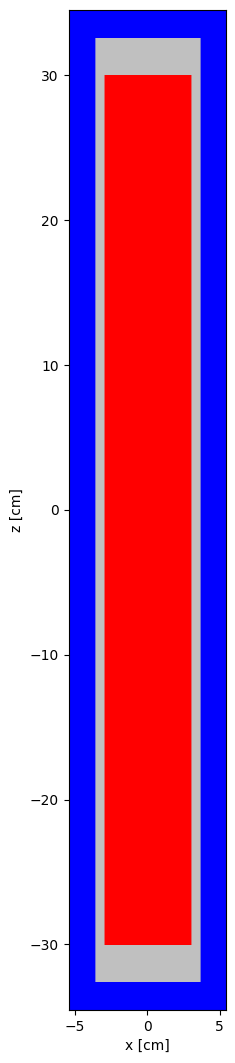

In [2]:
#####################################################################################
#                                   FUEL PLATE                                      #
#####################################################################################

fuel_top = mc.ZPlane(z0=30.01)
fuel_bottom = mc.ZPlane(z0=-30.01)
fuel_right = mc.XPlane(x0=2.98)
fuel_left = mc.XPlane(x0=-2.98)
fuel_front = mc.YPlane(y0=0.0255)
fuel_back = mc.YPlane(y0=-0.0255)

fuel_region = +fuel_bottom & -fuel_top & +fuel_left & -fuel_right & -fuel_front & +fuel_back

fuel_cell = mc.Cell(region=fuel_region, fill=fuel)


clad_top = mc.ZPlane(z0=32.55)
clad_bottom = mc.ZPlane(z0=-32.55)
clad_right = mc.XPlane(x0=3.615)
clad_left = mc.XPlane(x0=-3.615)
clad_front = mc.YPlane(y0=0.0635)
clad_back = mc.YPlane(y0=-0.0635)

clad_region = (+clad_bottom & -clad_top & +clad_left & -clad_right &
               -clad_front & +clad_back & ~fuel_region)

clad_cell = mc.Cell(region=clad_region, fill=Al6061)


dummy_cell= mc.Cell(fill=Al6061, region= +clad_bottom & -clad_top & +clad_left &
                                         -clad_right & -clad_front & +clad_back)

screw_1_cylinder = mc.YCylinder(r= 1.2, x0= -3.615/2, z0= 31.275)
screw_2_cylinder = mc.YCylinder(r= 1.2, x0 = 3.615/2, z0= 31.275)
screw_3_cylinder = mc.YCylinder(r= 1.2, x0= -3.615/2, z0= -31.275)
screw_4_cylinder = mc.YCylinder(r= 1.2, x0=  3.615/2, z0= -31.275)



coolant_region = ~clad_region & ~fuel_region & +screw_1_cylinder & +screw_2_cylinder & +screw_3_cylinder & +screw_4_cylinder

coolant = mc.Cell(region=coolant_region, fill=water)
coolant_2 = mc.Cell(region=coolant_region, fill=water)



infinite_air = mc.Cell(fill = air)
infinite_air_universe = mc.Universe()
infinite_air_universe.add_cell(infinite_air)


infinite_water = mc.Cell(fill = water)
infinite_water_universe = mc.Universe()
infinite_water_universe.add_cell(infinite_water)

infinite_graphite_cell = mc.Cell(fill=graphite)
infinite_graphite_universe = mc.Universe(cells=[infinite_graphite_cell])

infinite_cladding = mc.Cell(fill=Al6061)
infinite_cladding_universe = mc.Universe(cells=[infinite_cladding])

infinite_barite_concrete = mc.Cell(fill=barite_concrete)
infinite_barite_concrete_universe = mc.Universe(cells=[infinite_barite_concrete])



screw_1 = mc.Cell(fill= Al6061, region= -screw_1_cylinder & ~fuel_region & ~ clad_region)
screw_2 = mc.Cell(fill= Al6061, region= -screw_2_cylinder & ~fuel_region & ~ clad_region)
screw_3 = mc.Cell(fill= Al6061, region= -screw_3_cylinder & ~fuel_region & ~ clad_region)
screw_4 = mc.Cell(fill= Al6061, region= -screw_4_cylinder & ~fuel_region & ~ clad_region)

screw_11 = mc.Cell(fill= Al6061, region= -screw_1_cylinder & ~fuel_region & ~clad_region)
screw_22 = mc.Cell(fill= Al6061, region= -screw_2_cylinder & ~fuel_region & ~clad_region)
screw_33 = mc.Cell(fill= Al6061, region= -screw_3_cylinder & ~fuel_region & ~clad_region)
screw_44 = mc.Cell(fill= Al6061, region= -screw_4_cylinder & ~fuel_region & ~clad_region)


fuel_plate = mc.Universe(cells=[fuel_cell, clad_cell, coolant, screw_1, screw_2, screw_3, screw_4])


fuel_plate.plot(colors=colors, color_by='material', width=(3.615 * 3, 32.55 * 2.12), origin= (0,0,0),
                pixels = (1000, 1000), basis= 'xz')

dummy_plate= mc.Universe(cells=[dummy_cell, coolant_2, screw_11, screw_22, screw_33, screw_44])

Now that a fuel plate and a dummy plate are created, we can start constructing an assembly using the lattice method to duplicate elements, there are three types of assemblies we will create for future use:

 1- fuel_assembly_universe: contains a regular arrangement of 14 parallel fuel plates
 2- partial_dummy_assembly_universe: Contains 4 fuel plates on the north side, and 10 dummy plates on the south side
 3- dummy_assembly_universe: contains 14 dummy plates with no fuel at all
 
These assemblies were done using the same approach for one plate, which is surrounding it with infinite water to replicate it later on and create a fuel box.

<Axes: xlabel='y [cm]', ylabel='z [cm]'>

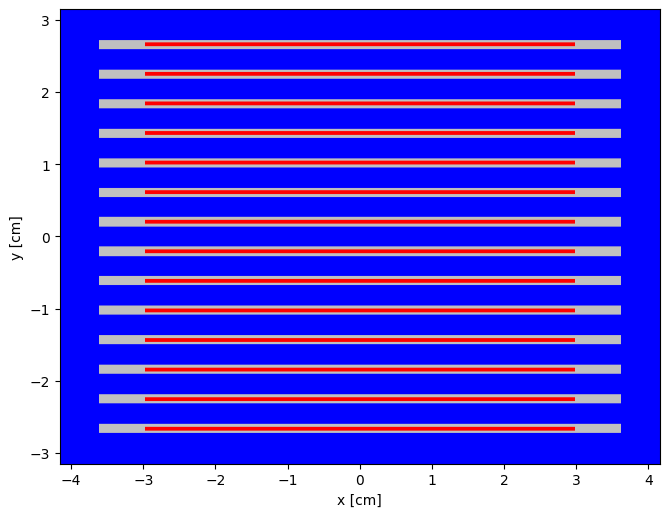

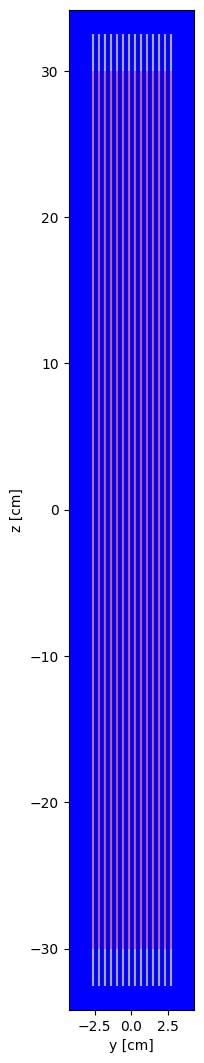

In [3]:
#####################################################################################
#                                   FUEL ASSEMBLY                                   #
#####################################################################################

fuel_assembly = mc.RectLattice(name = 'fuel assembly')
fuel_assembly.lower_left = (-3.615, -2.863)
fuel_assembly.pitch = (7.23, 0.409)
fuel_assembly.universes = [[fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate],
                           [fuel_plate]]

fuel_assembly.outer = infinite_water_universe
fuel_assembly_cell = mc.Cell()
fuel_assembly_cell.fill = fuel_assembly

dummy_assembly = mc.RectLattice(name = 'dummy assembly')
dummy_assembly.lower_left = (-3.615, -2.863)
dummy_assembly.pitch = (7.23, 0.409)
dummy_assembly.universes = [[dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate],
                            [dummy_plate]]

dummy_assembly.outer = infinite_water_universe
dummy_assembly_cell = mc.Cell()
dummy_assembly_cell.fill = dummy_assembly

partial_dummy_assembly = mc.RectLattice(name = 'dummy assembly')
partial_dummy_assembly.lower_left = (-3.615, -2.863)
partial_dummy_assembly.pitch = (7.23, 0.409)
partial_dummy_assembly.universes = [[fuel_plate],
                                    [fuel_plate],
                                    [fuel_plate],
                                    [fuel_plate],
                                    [dummy_plate],
                                    [dummy_plate],
                                    [dummy_plate],
                                    [dummy_plate],
                                    [dummy_plate],
                                    [dummy_plate],
                                    [dummy_plate],
                                    [dummy_plate],
                                    [dummy_plate]]
                                    
partial_dummy_assembly.outer = infinite_water_universe
partial_dummy_assembly_cell = mc.Cell()
partial_dummy_assembly_cell.fill = partial_dummy_assembly


fuel_assembly_universe = mc.Universe()
fuel_assembly_universe.add_cell(fuel_assembly_cell)

dummy_assembly_universe = mc.Universe()
dummy_assembly_universe.add_cell(dummy_assembly_cell)

partial_dummy_assembly_universe = mc.Universe(cells=[partial_dummy_assembly_cell])

fuel_assembly_universe.plot(colors=colors, color_by='material', width=(7.23 * 1.15, 2.863 * 2.2),
                            origin= (0,0,0), pixels=(600,600), basis= 'xy')

fuel_assembly_universe.plot(colors=colors, color_by='material', width=(2.863 * 3,32.55 * 2.1),
                            origin = (0,0,0), pixels=(1000,1000), basis= 'yz')

Now that all types of useful assemblies are created, we can start constructing the fuel boxes, 3 fuel box types will be created:
1- fuel_box_universe: containing 4 fuel assemblies
2- dummy_box_universe_1: containing 3 fuel assemblies and 1 complete dummy assembly
3- dummy_box_universe_2: also containing 3 fuel assemblies and 1 complete dummy assembly, but with the dummy at different position

from these universes, 6 fuel box cells are created matching their configuration in the core

A small air gap was added at the top of the box, this is mentioned in tech specs, as there is a coolant outlet before the top, which means that water flows from the bottom to the top and exits before reaching the top as that is where the outlet is placed, about 4 cm below the top, at one of the sides of the box walls.

<Axes: xlabel='y [cm]', ylabel='z [cm]'>

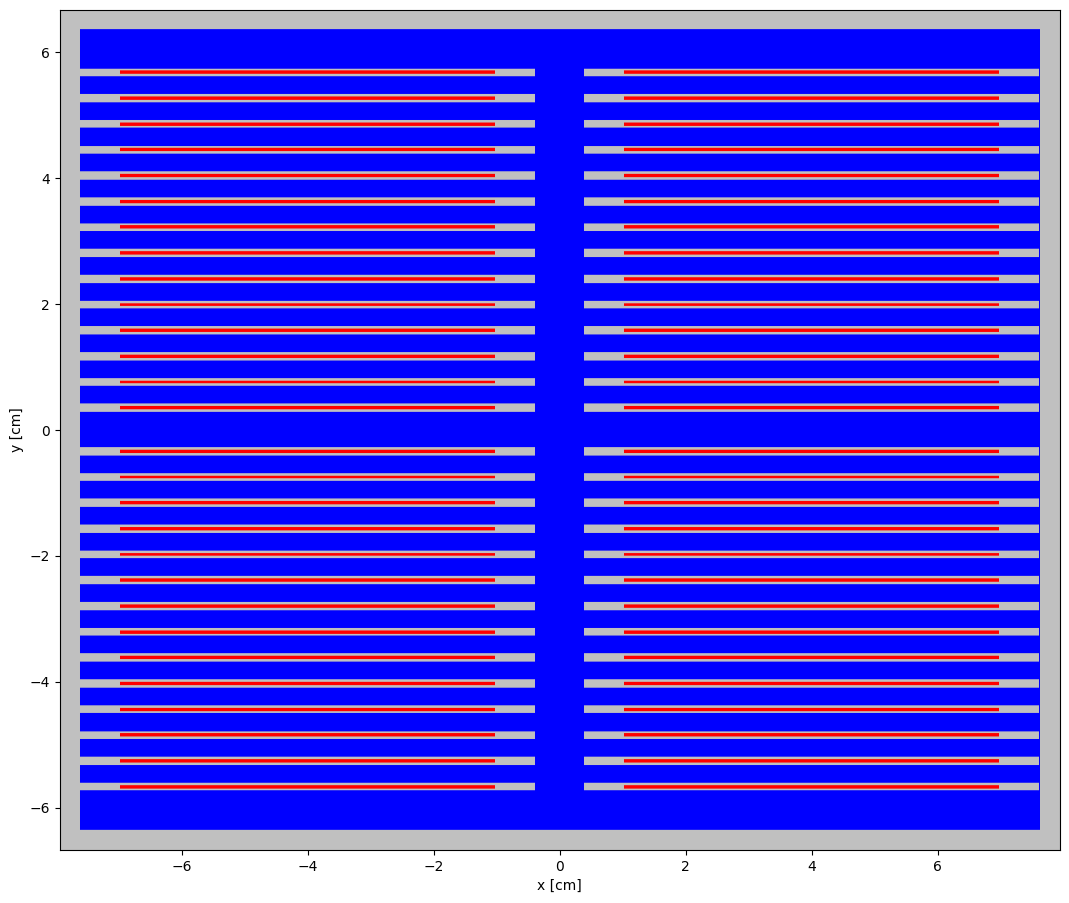

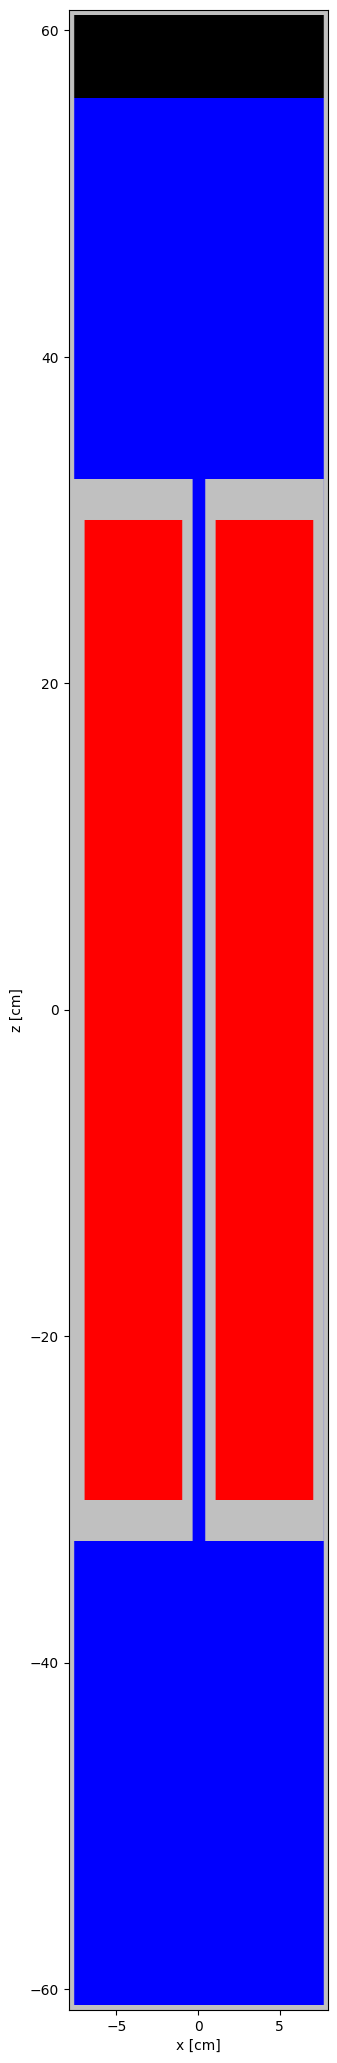

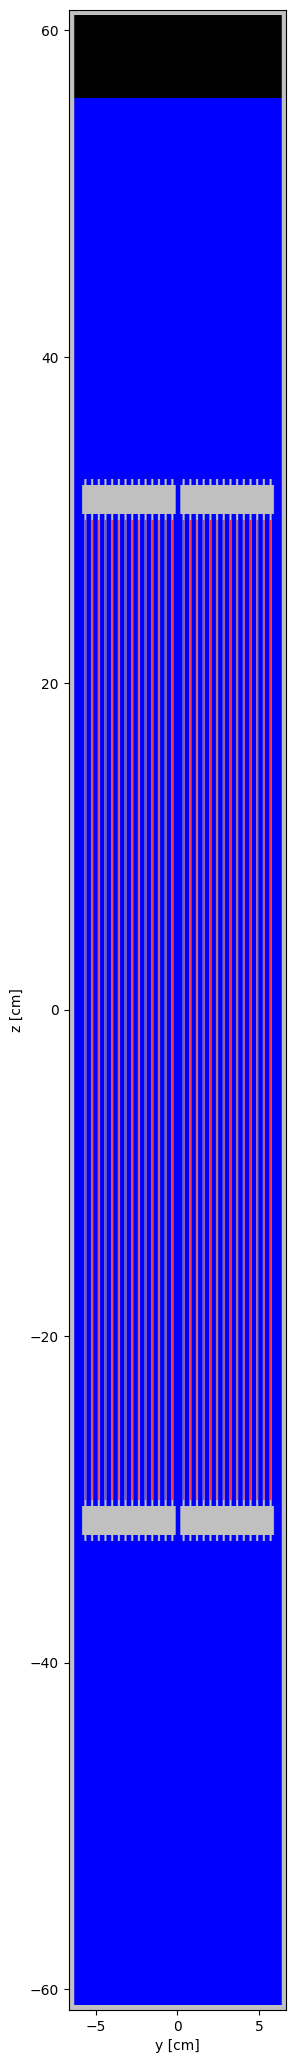

In [4]:
#####################################################################################
#                                     FUEL BOXES                                    #
#####################################################################################

fuel_box = mc.RectLattice(name = 'fuel box')
fuel_box.lower_left = (-8.01, -5.726 - 0.282)
fuel_box.pitch = (8.005, 5.726 + 0.282)

fuel_box.universes = [[fuel_assembly_universe, fuel_assembly_universe],
                      [fuel_assembly_universe, fuel_assembly_universe]]

fuel_box.outer = mc.Universe(cells=[mc.Cell(fill= water)], name='water surrounding fuel assembly lattice')
fuel_box_cell = mc.Cell()
fuel_box_cell.fill = fuel_box


right_box_inner_boundary = mc.XPlane(x0= 7.62)
left_box_inner_boundary = mc.XPlane(x0= -7.62)
front_box_inner_boundary = mc.YPlane(y0= 6.35)
back_box_inner_boundary = mc.YPlane(y0= -6.35)
top_box_inner_boundary = mc.ZPlane(z0= 60.95)
top_box_water_boundary = mc.ZPlane(z0= 60.95 - 5.08)
bottom_box_inner_boundary = mc.ZPlane(z0= -60.95)

right_box_outer_boundary = mc.XPlane(x0= 7.62 +0.318)
left_box_outer_boundary = mc.XPlane(x0= -7.62 -0.318)
front_box_outer_boundary = mc.YPlane(y0= 6.35 +0.318)
back_box_outer_boundary = mc.YPlane(y0= -6.35 -0.318)
top_box_outer_boundary = mc.ZPlane(z0= 60.95 +0.318)
bottom_box_outer_boundary = mc.ZPlane(z0= -60.95 -0.318)


fuel_box_dummy_1 = mc.RectLattice(name = 'fuel box with dummy assembly')
fuel_box_dummy_1.lower_left = (-8.01, -5.726 - 0.282)
fuel_box_dummy_1.pitch = (8.005, 5.726 + 0.282)

fuel_box_dummy_1.universes = [[fuel_assembly_universe, fuel_assembly_universe],
                            [fuel_assembly_universe, dummy_assembly_universe]]

fuel_box_dummy_1.outer = mc.Universe(cells=[mc.Cell(fill= water)], name='water surrounding fuel assembly lattice')
fuel_box_dummy_1_cell = mc.Cell()
fuel_box_dummy_1_cell.fill = fuel_box_dummy_1

fuel_box_dummy_2 = mc.RectLattice(name = 'fuel box with partial dummy assembly')
fuel_box_dummy_2.lower_left = (-8.01, -5.726 - 0.282)
fuel_box_dummy_2.pitch = (8.005, 5.726 + 0.282)

fuel_box_dummy_2.universes = [[fuel_assembly_universe, dummy_assembly_universe],
                                    [fuel_assembly_universe, fuel_assembly_universe]]

fuel_box_dummy_2.outer = mc.Universe(cells=[mc.Cell(fill= water)], name='water surrounding fuel assembly lattice')
fuel_box_dummy_2_cell = mc.Cell()
fuel_box_dummy_2_cell.fill = fuel_box_dummy_2



fuel_box_cell.region = (-right_box_inner_boundary & +left_box_inner_boundary & -front_box_inner_boundary 
                        & +back_box_inner_boundary & -top_box_water_boundary & +bottom_box_inner_boundary)

fuel_box_air_region = (-right_box_inner_boundary & +left_box_inner_boundary & -front_box_inner_boundary &
                       +back_box_inner_boundary & +top_box_water_boundary & -top_box_inner_boundary)

fuel_box_wall_region = (-right_box_outer_boundary & +left_box_outer_boundary & -front_box_outer_boundary & 
                        +back_box_outer_boundary & -top_box_outer_boundary & +bottom_box_outer_boundary & 
                        ~fuel_box_cell.region & ~fuel_box_air_region)

fuel_box_wall = mc.Cell(fill=Al6061, region=fuel_box_wall_region)
fuel_box_wall_1 = mc.Cell(fill=Al6061, region=fuel_box_wall_region)
fuel_box_wall_2 = mc.Cell(fill=Al6061, region=fuel_box_wall_region)

fuel_box_air = mc.Cell(fill=air, region=fuel_box_air_region)
fuel_box_air_1 = mc.Cell(fill=air, region=fuel_box_air_region)
fuel_box_air_2 = mc.Cell(fill=air, region=fuel_box_air_region)

fuel_box_dummy_1_cell.region = fuel_box_cell.region
fuel_box_dummy_2_cell.region = fuel_box_cell.region


box_air = mc.Cell(fill=air, region= (~fuel_box_cell.region & ~fuel_box_wall_region))
box_air_1 = mc.Cell(fill=air, region= (~fuel_box_cell.region & ~fuel_box_wall_region))
box_air_2 = mc.Cell(fill=air, region= (~fuel_box_cell.region & ~fuel_box_wall_region))

fuel_box_universe = mc.Universe(cells=[fuel_box_cell, fuel_box_wall, fuel_box_air])
dummy_box_universe = mc.Universe(cells=[fuel_box_dummy_1_cell, fuel_box_wall_1, fuel_box_air_1])
partial_dummy_box_universe = mc.Universe(cells=[fuel_box_dummy_2_cell, fuel_box_wall_2, fuel_box_air_2])



fuel_box_1_cell = mc.Cell(fill= fuel_box_universe)
fuel_box_2_cell = mc.Cell(fill= fuel_box_universe)
fuel_box_3_cell = mc.Cell(fill= dummy_box_universe)
fuel_box_4_cell = mc.Cell(fill= fuel_box_universe)
fuel_box_5_cell = mc.Cell(fill= fuel_box_universe)
fuel_box_6_cell = mc.Cell(fill= partial_dummy_box_universe)

BOX_WIDTH = 15.876
BOX_LENGTH = 13.336
BOX_HEIGHT = 122.536

fuel_box_universe.plot(colors=colors, color_by='material', width=(BOX_WIDTH, BOX_LENGTH),
                       pixels=(1000,1000), basis= 'xy', origin= (0, 0, 0))
fuel_box_universe.plot(colors=colors, color_by='material', width=(BOX_WIDTH, BOX_HEIGHT),
                       pixels=(2000,2000), basis= 'xz', origin= (0, 2, 0))
fuel_box_universe.plot(colors=colors, color_by='material', width=(BOX_LENGTH, BOX_HEIGHT),
                       pixels=(2000,2000), basis= 'yz', origin= (3, 0, 0))

Unfortunately, this is as far as we can go with replication in this geometry setup. Initially, replication was used to create a single box. However, further replication to simplify the construction of the geometry is not feasible. This limitation is due to the core's non-uniform nature and OpenMC's requirements for replication, which are uniformity and the absence of gaps within the replicated bulk of geometry.

Even if we attempted to replicate the fuel boxes and control blades together to meet the uniformity requirement, this approach would still fall short. The blades and boxes do not share the same dimensions, making them non-uniform structures that cannot be uniformly replicated.

Therefore, the only feasible approach from here is to manually create six separate boxes and translate each to its intended position within the core, then apply a region command on each box to ensure no gaps or overlaps. This process is lengthy but necessary given the core's configuration and the dimensional discrepancies between the different components.

In [5]:
SHROUD_WIDTH = 2.54
SHROUD_LENGTH = 90.4
SHROUD_HEIGHT = 91.4

BOX_Y_SPACING = 30.48

SHROUD_X_SPACING = (BOX_WIDTH/2) + SHROUD_WIDTH/2
SHROUD_Y_SPACING = (SHROUD_LENGTH/2) + BOX_Y_SPACING/2 - 2.22 


fuel_box_1_cell.translation = (-BOX_WIDTH - SHROUD_WIDTH, -(BOX_LENGTH/2)-(BOX_Y_SPACING/2), 0)

box_1_back = mc.YPlane(y0=- (BOX_LENGTH)-(BOX_Y_SPACING/2))
box_1_front = mc.YPlane(y0= -BOX_Y_SPACING/2)
box_1_right = mc.XPlane(x0=- BOX_WIDTH/2- SHROUD_WIDTH)
box_1_left = mc.XPlane(x0=- BOX_WIDTH/2 - SHROUD_WIDTH - BOX_WIDTH)

fuel_box_1_cell.region = (-box_1_right & +box_1_left & -box_1_front &
                          +box_1_back & -top_box_outer_boundary & +bottom_box_outer_boundary)




fuel_box_2_cell.translation = (0, -(BOX_LENGTH/2)-(BOX_Y_SPACING/2), 0)

box_2_back = box_1_back
box_2_front = box_1_front
box_2_right = right_box_outer_boundary
box_2_left = left_box_outer_boundary

fuel_box_2_cell.region = (-box_2_right & +box_2_left & -box_2_front &
                          +box_2_back & -top_box_outer_boundary & +bottom_box_outer_boundary)




fuel_box_3_cell.translation = (BOX_WIDTH + SHROUD_WIDTH, -(BOX_LENGTH/2)-(BOX_Y_SPACING/2), 0)

box_3_back = box_1_back
box_3_front = box_1_front
box_3_right = mc.XPlane(x0= BOX_WIDTH/2 + SHROUD_WIDTH + BOX_WIDTH)
box_3_left = mc.XPlane(x0= BOX_WIDTH/2 + SHROUD_WIDTH)

fuel_box_3_cell.region = (-box_3_right & +box_3_left & -box_3_front &
                          +box_3_back & -top_box_outer_boundary & +bottom_box_outer_boundary)




fuel_box_4_cell.translation = (-BOX_WIDTH - SHROUD_WIDTH, (BOX_LENGTH/2)+(BOX_Y_SPACING/2), 0)

box_4_back = mc.YPlane(y0= BOX_Y_SPACING/2)
box_4_front = mc.YPlane(y0= 28.576)
box_4_right = box_1_right
box_4_left = box_1_left

fuel_box_4_cell.region = (-box_4_right & +box_4_left & -box_4_front &
                          +box_4_back & -top_box_outer_boundary & +bottom_box_outer_boundary)




fuel_box_5_cell.translation = (0, (BOX_LENGTH/2)+(BOX_Y_SPACING/2), 0)

box_5_back = box_4_back
box_5_front = box_4_front
box_5_right = box_2_right
box_5_left = box_2_left

fuel_box_5_cell.region = (-box_5_right & +box_5_left & -box_5_front &
                          +box_5_back & -top_box_outer_boundary & +bottom_box_outer_boundary)




fuel_box_6_cell.translation = (BOX_WIDTH + SHROUD_WIDTH, (BOX_LENGTH/2)+(BOX_Y_SPACING/2), 0)

box_6_back = box_4_back
box_6_front = box_4_front
box_6_right = box_3_right
box_6_left = box_3_left

fuel_box_6_cell.region = (-box_6_right & +box_6_left & -box_6_front & +box_6_back
                           & -top_box_outer_boundary & +bottom_box_outer_boundary)

Now that the boxes are constructed and positioned into place as individual cells, we need to start building the control blades, which is the trickiest part of this geometry, the problem with them is that we need to simulate the withdrawal and insertion of the blades, which is not an easy task at all, so first as always, a single universe of a single blade is created, which includes the magnesium shroud, the aluminum blade, and the cadmium tip. The method was as follows, 3 cells are created, aluminum, cadmium within it (making the blade), infinite air around the blade, these cells are fused together by creating a universe containing all of them, then this universe is immediately converted into one cell, containing a blade, and infinite air around it, it is then replicated to create the 4 blades, two of them are rotated 180 degrees to face the other direction as 2 blades face north and 2 face south. The cells are translated so that the center of each is at the point of rotation (the tip of the blade of which the gear rotates the blades in real life), after rotation, the blades are translated in their corresponding position inside the shroud. Now, after all this complication, a single line command is available to rotate each blade in degrees for each blade which is identical to reality, this command is highlighted in the cell below with comments (you won't miss it (: ). after the rotation, the blades are translated back into their original places, then another translation is done the same way the boxes are translated, to position them were they are in the core also the same region command is applied to make sure there are no overlaps or voids in the geometry.

In [9]:
#####################################################################################
#                                 CONTROL BLADES                                    #
#####################################################################################

SHROUD_THICKNESS = (2.54-1.9)/2
SHROUD_X_INNER = 1.9
INCLINE_SLOPE = (34.3-10.8)/61.9
DECLINED_SLOPE = (27.9-34.3)/12.7
BLADE_THICKNESS = 0.259
Cd_THICKNESS = 0.102

shroud_inner_top = mc.ZPlane(z0=SHROUD_HEIGHT/2 - SHROUD_THICKNESS)
shroud_inner_bottom = mc.ZPlane(z0=-SHROUD_HEIGHT/2 + SHROUD_THICKNESS)
shroud_inner_front = mc.YPlane(y0=SHROUD_LENGTH/2 - SHROUD_THICKNESS)
shroud_inner_back = mc.YPlane(y0=-SHROUD_LENGTH/2 + SHROUD_THICKNESS)
shroud_inner_right = mc.XPlane(x0=SHROUD_X_INNER/2)
shroud_inner_left = mc.XPlane(x0=-SHROUD_X_INNER/2)

shroud_outer_top = mc.ZPlane(z0=SHROUD_HEIGHT/2)
shroud_outer_bottom = mc.ZPlane(z0=-SHROUD_HEIGHT/2)
shroud_outer_front = mc.YPlane(y0=SHROUD_LENGTH/2)
shroud_outer_back = mc.YPlane(y0=-SHROUD_LENGTH/2)
shroud_outer_right = mc.XPlane(x0=SHROUD_X_INNER/2 + SHROUD_THICKNESS)
shroud_outer_left = mc.XPlane(x0=-SHROUD_X_INNER/2 - SHROUD_THICKNESS)

shroud_inner_region = (-shroud_inner_top & +shroud_inner_bottom & -shroud_inner_front & 
                       +shroud_inner_back & -shroud_inner_right & +shroud_inner_left)

shroud_outer_region = (-shroud_outer_top & +shroud_outer_bottom & -shroud_outer_front & 
                       +shroud_outer_back & -shroud_outer_right & +shroud_outer_left)

shroud_region = shroud_outer_region & ~ shroud_inner_region

shroud_cell = mc.Cell(fill=magnesium, region= shroud_region)
shroud_universe = mc.Universe(cells= [shroud_cell])

shroud_cell_1 = mc.Cell(fill= shroud_universe, region= shroud_region)
shroud_cell_2 = mc.Cell(fill= shroud_universe, region= shroud_region)
shroud_cell_3 = mc.Cell(fill= shroud_universe, region= shroud_region)
shroud_cell_4 = mc.Cell(fill= shroud_universe, region= shroud_region)



# y and z surfaces are mutual for the whole blade, so both aluminum and cadmium share the same surfaces
blade_inclination = mc.Plane(a=0, b=-INCLINE_SLOPE, c=1, d=5.4)
blade_declination = mc.Plane(a=0, b= -DECLINED_SLOPE, c= 1, d= 76319/1270)
safety_blade_mid_interception = mc.YPlane(y0=61.9)
regulating_blade_mid_interception = mc.YPlane(y0= 61.9 + 12.7 - 4.57) # Regulating blades have lower amount of cadmium compared to safety blades
blade_bottom = mc.ZPlane(z0=-10.8/2)
blade_front = mc.YPlane(y0= 61.9+12.7)
blade_back = mc.YPlane(y0= 0)

# x surfaces are where the distinction happen between Cadmium and Aluminum
aluminum_outer_right = mc.XPlane(x0= BLADE_THICKNESS/2)
aluminum_outer_left = mc.XPlane(x0= -BLADE_THICKNESS/2)
aluminum_inner_right = mc.XPlane(x0= +Cd_THICKNESS/2)
aluminum_inner_left = mc.XPlane(x0= -Cd_THICKNESS/2)
test_upper = mc.ZPlane(z0= 35)

blade_region = (-blade_inclination & -blade_declination & + blade_bottom & + blade_back & -blade_front &
                    + aluminum_outer_left & -aluminum_outer_right)

safety_cadmium_region = (+safety_blade_mid_interception & -blade_front & -blade_declination &
                         +blade_bottom & -aluminum_inner_right & +aluminum_inner_left)

regulating_cadmium_region = (+regulating_blade_mid_interception & -blade_front & -blade_declination &
                         +blade_bottom & -aluminum_inner_right & +aluminum_inner_left)

safety_aluminum_blade_cell = mc.Cell(fill=Al6061, region= blade_region & ~safety_cadmium_region)

safety_cadmium_blade_cell = mc.Cell(fill=cadmium, region= safety_cadmium_region)


regulating_aluminum_blade_cell = mc.Cell(fill=Al6061, region= blade_region & ~regulating_cadmium_region)

regulating_cadmium_blade_cell = mc.Cell(fill=cadmium, region= regulating_cadmium_region)



safety_blade_universe = mc.Universe(cells=[safety_aluminum_blade_cell, safety_cadmium_blade_cell])

regulating_blade_universe = mc.Universe(cells=[regulating_aluminum_blade_cell, regulating_cadmium_blade_cell])


'''
now we have to create three cells for each of the safety blades, the reason for creating them like this is that we
have to have the ability to apply methods on the specific cell to withdraw it, as it is with draw in vertical rotation
'''
safety_blade_1_temporary_cell = mc.Cell(fill= safety_blade_universe, region= blade_region)
safety_blade_2_temporary_cell = mc.Cell(fill= safety_blade_universe, region= blade_region)
safety_blade_3_temporary_cell = mc.Cell(fill= safety_blade_universe, region= blade_region)
regulating_blade_temporary_cell = mc.Cell(fill= regulating_blade_universe, region= blade_region)

'''
now we need to apply translation to each cell to make the center of the cell the origin of 
rotation, then apply rotation, then add them to a universe then to their individual final cell 
'''



safety_blade_1_universe = mc.Universe(cells=[safety_blade_1_temporary_cell, mc.Cell(fill=air, region=~blade_region)])
safety_blade_1_rotation_cell = mc.Cell(fill= safety_blade_1_universe)

safety_blade_2_universe = mc.Universe(cells=[safety_blade_2_temporary_cell, mc.Cell(fill=air, region=~blade_region)])
safety_blade_2_rotation_cell = mc.Cell(fill= safety_blade_2_universe)

safety_blade_3_universe = mc.Universe(cells=[safety_blade_3_temporary_cell, mc.Cell(fill=air, region=~blade_region)])
safety_blade_3_rotation_cell = mc.Cell(fill= safety_blade_3_universe)

regulating_blade_universe = mc.Universe(cells=[regulating_blade_temporary_cell, mc.Cell(fill=air, region=~blade_region)])
regulating_blade_rotation_cell = mc.Cell(fill= regulating_blade_universe)



#######################################################################################################################################################
#######################################################################################################################################################

# BLADE INSERTION AND WITHDRAWAL: Blades rotate between 0 and 45 degrees, but in the control room, it is normalized out of 1000, 1000 being fully withdrawn which corresponds to 45 degrees, and 0 being fully inserted corresponding to 0 degrees

# The critical position of UFTR in 2006 when the core was fresh ====> Safety Blades 1,2,3 = 570 ---- Regulating Blade = 320

#######################################################################################################################################################
                                                                  #####################################################################################
safety_blade_1_rotation_cell.rotation = (570/(200/9),0,0)         #####################################################################################
                                                                  #####################################################################################
safety_blade_2_rotation_cell.rotation = (570/(200/9),0,0)         #####################################################################################
                                                                  #####################################################################################
safety_blade_3_rotation_cell.rotation = (570/(200/9),0,0)         #####################################################################################
                                                                  #####################################################################################
                                                                  #####################################################################################
regulating_blade_rotation_cell.rotation = (320/(200/9),0,0)       #####################################################################################
                                                                  #####################################################################################
#######################################################################################################################################################
#######################################################################################################################################################

# Now translating blades back into their actual position inside the shroud

safety_blade_1_rotation_cell.translation = (0,-34.8, -27.9)
safety_blade_2_rotation_cell.translation = (0,-34.8, -27.9)
safety_blade_3_rotation_cell.translation = (0,-34.8, -27.9)
regulating_blade_rotation_cell.translation = (0,-34.8, -27.9)

Now after the 4 blades are created, and rotated inside their local coordinates to simulate blades withdrawal and insertion , it's time to put these blades inside a shroud which was created before as a universe from which 4 shroud cells were created, then each blade along with its shroud is translated into its corresponding position inside the core

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

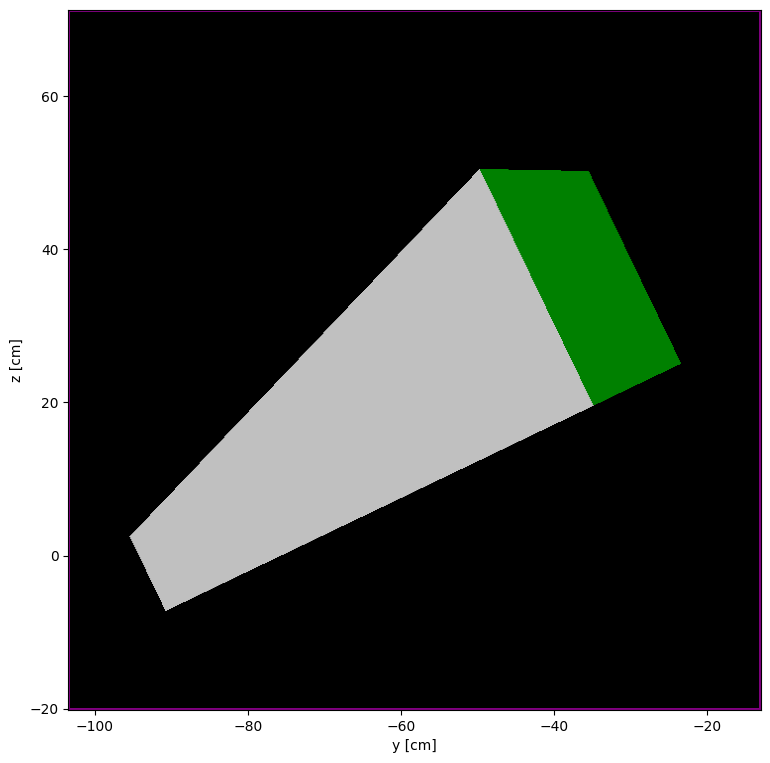

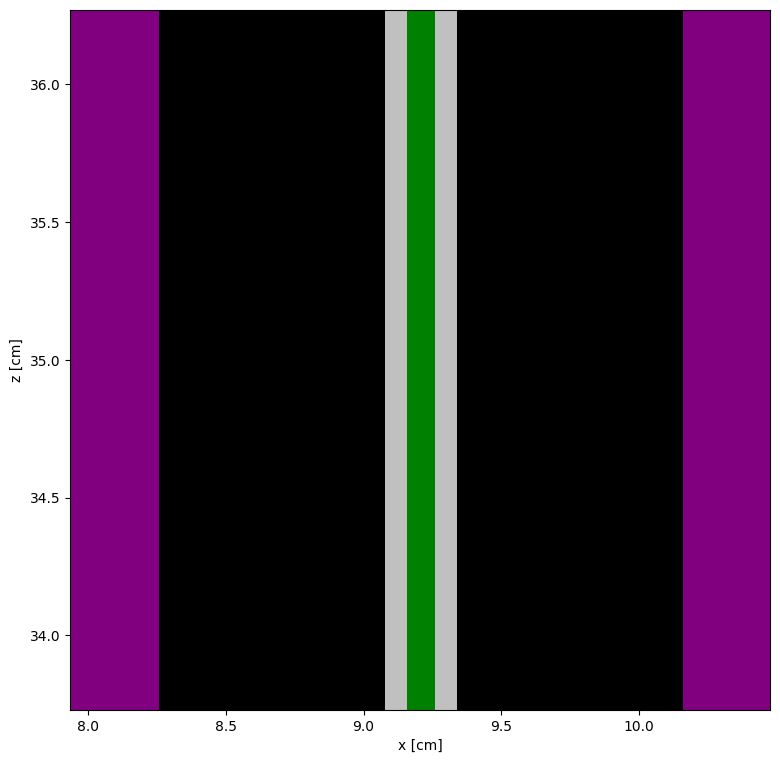

In [10]:
safety_blade_1_rotation_cell.region = shroud_inner_region

safety_blade_1_universe = mc.Universe(cells=[shroud_cell_1, safety_blade_1_rotation_cell])
safety_blade_1_cell = mc.Cell(fill=safety_blade_1_universe)

safety_blade_1_cell.translation = (SHROUD_X_SPACING, -SHROUD_Y_SPACING, 25.568)

blade_1_back = mc.YPlane(y0= (-BOX_Y_SPACING/2)+2.22-SHROUD_LENGTH)
blade_1_front = mc.YPlane(y0= (-BOX_Y_SPACING/2)+2.22)
blade_1_bottom = mc.ZPlane(z0= -20.132)
blade_1_top = mc.ZPlane(z0= 71.268)
blade_1_right = box_2_right
blade_1_left = box_3_left


safety_blade_1_cell.region = (+blade_1_right & - blade_1_left & +blade_1_back &
                              -blade_1_front & - blade_1_top & + blade_1_bottom)




safety_blade_2_rotation_cell.region = shroud_inner_region

safety_blade_2_universe = mc.Universe(cells=[shroud_cell_2, safety_blade_2_rotation_cell])
safety_blade_2_cell = mc.Cell(fill=safety_blade_2_universe)

safety_blade_2_cell.translation = (-SHROUD_X_SPACING, -SHROUD_Y_SPACING, 25.568)

blade_2_back = blade_1_back
blade_2_front = blade_1_front
blade_2_bottom = blade_1_bottom
blade_2_top = blade_1_top
blade_2_right = box_1_right
blade_2_left = box_2_left

safety_blade_2_cell.region = (+blade_2_right & -blade_2_left & +blade_2_back &
                              -blade_2_front & - blade_2_top & + blade_2_bottom)




safety_blade_3_rotation_cell.region = shroud_inner_region

safety_blade_3_universe = mc.Universe(cells=[shroud_cell_3, safety_blade_3_rotation_cell])
safety_blade_3_cell = mc.Cell(fill=safety_blade_3_universe)

safety_blade_3_cell.rotation = (0,0,180)
safety_blade_3_cell.translation = (-SHROUD_X_SPACING, SHROUD_Y_SPACING, 25.568)

blade_3_back = mc.YPlane(y0= (BOX_Y_SPACING/2)-2.22+SHROUD_LENGTH)
blade_3_front = mc.YPlane(y0= (BOX_Y_SPACING/2)-2.22)
blade_3_bottom = blade_1_bottom
blade_3_top = blade_1_top
blade_3_right = box_5_left
blade_3_left = box_4_right

safety_blade_3_cell.region = (-blade_3_back & +blade_3_front & + blade_3_bottom &
                              - blade_3_top & -blade_3_right & +blade_3_left)



regulating_blade_rotation_cell.region = shroud_inner_region

regulating_blade_universe = mc.Universe(cells=[shroud_cell_4, regulating_blade_rotation_cell])
regulating_blade_cell = mc.Cell(fill=regulating_blade_universe)

regulating_blade_cell.rotation = (0,0,180)
regulating_blade_cell.translation = (SHROUD_X_SPACING, SHROUD_Y_SPACING, 25.568)



regulating_blade_back = blade_3_back
regulating_blade_front = blade_3_front
regulating_blade_bottom = blade_1_bottom
regulating_blade_top = blade_1_top
regulating_blade_right = box_6_left
regulating_blade_left = box_5_right

regulating_blade_cell.region = (-regulating_blade_back & +regulating_blade_front & + regulating_blade_bottom 
                                & -regulating_blade_top & -regulating_blade_right & +regulating_blade_left)

safety_blade_1_cell.plot(width=(90.4, 91.4), basis='yz', pixels=(700,700),
                         colors=colors, color_by='material')

safety_blade_1_cell.plot(basis='xz', width=(2.54, 2.54), origin= (9.205,-30,35),
                         pixels=(700,700), colors=colors, color_by='material')

Now that the fuel boxes and control blades are created, we need to create the surrounding materials, these are:
 1- the graphite reflector, which is created in 3 separate stages, graphite_cell_1 which is most of the graphite around the fuel, graphite_cell_2 which is an extension of graphite on top of the fuel boxes.
 2- Rabbit tube, thermal column, and vertical beam ports. 
 3- Water shield tank to the left of the core
 4- Air filling the gaps in between
 5- concrete shielding
 
After all these cells are created, a final root universe which houses the complete geometry is added in which all the cells are added, the 6 fuel cells, the 4 control blades, the graphite cells, the rabbit tubes, thermal column, vertical beams, the water shield, the air filling, and the concrete shielding. 

The method followed which is creating each cell individually, translating it into place and applying a region function on it to ensure no overlaps or gaps is not conventional and takes time, a better approach would be replication through lattices, but due to the core configuration, it is not possible, as the core region is asymmetric.

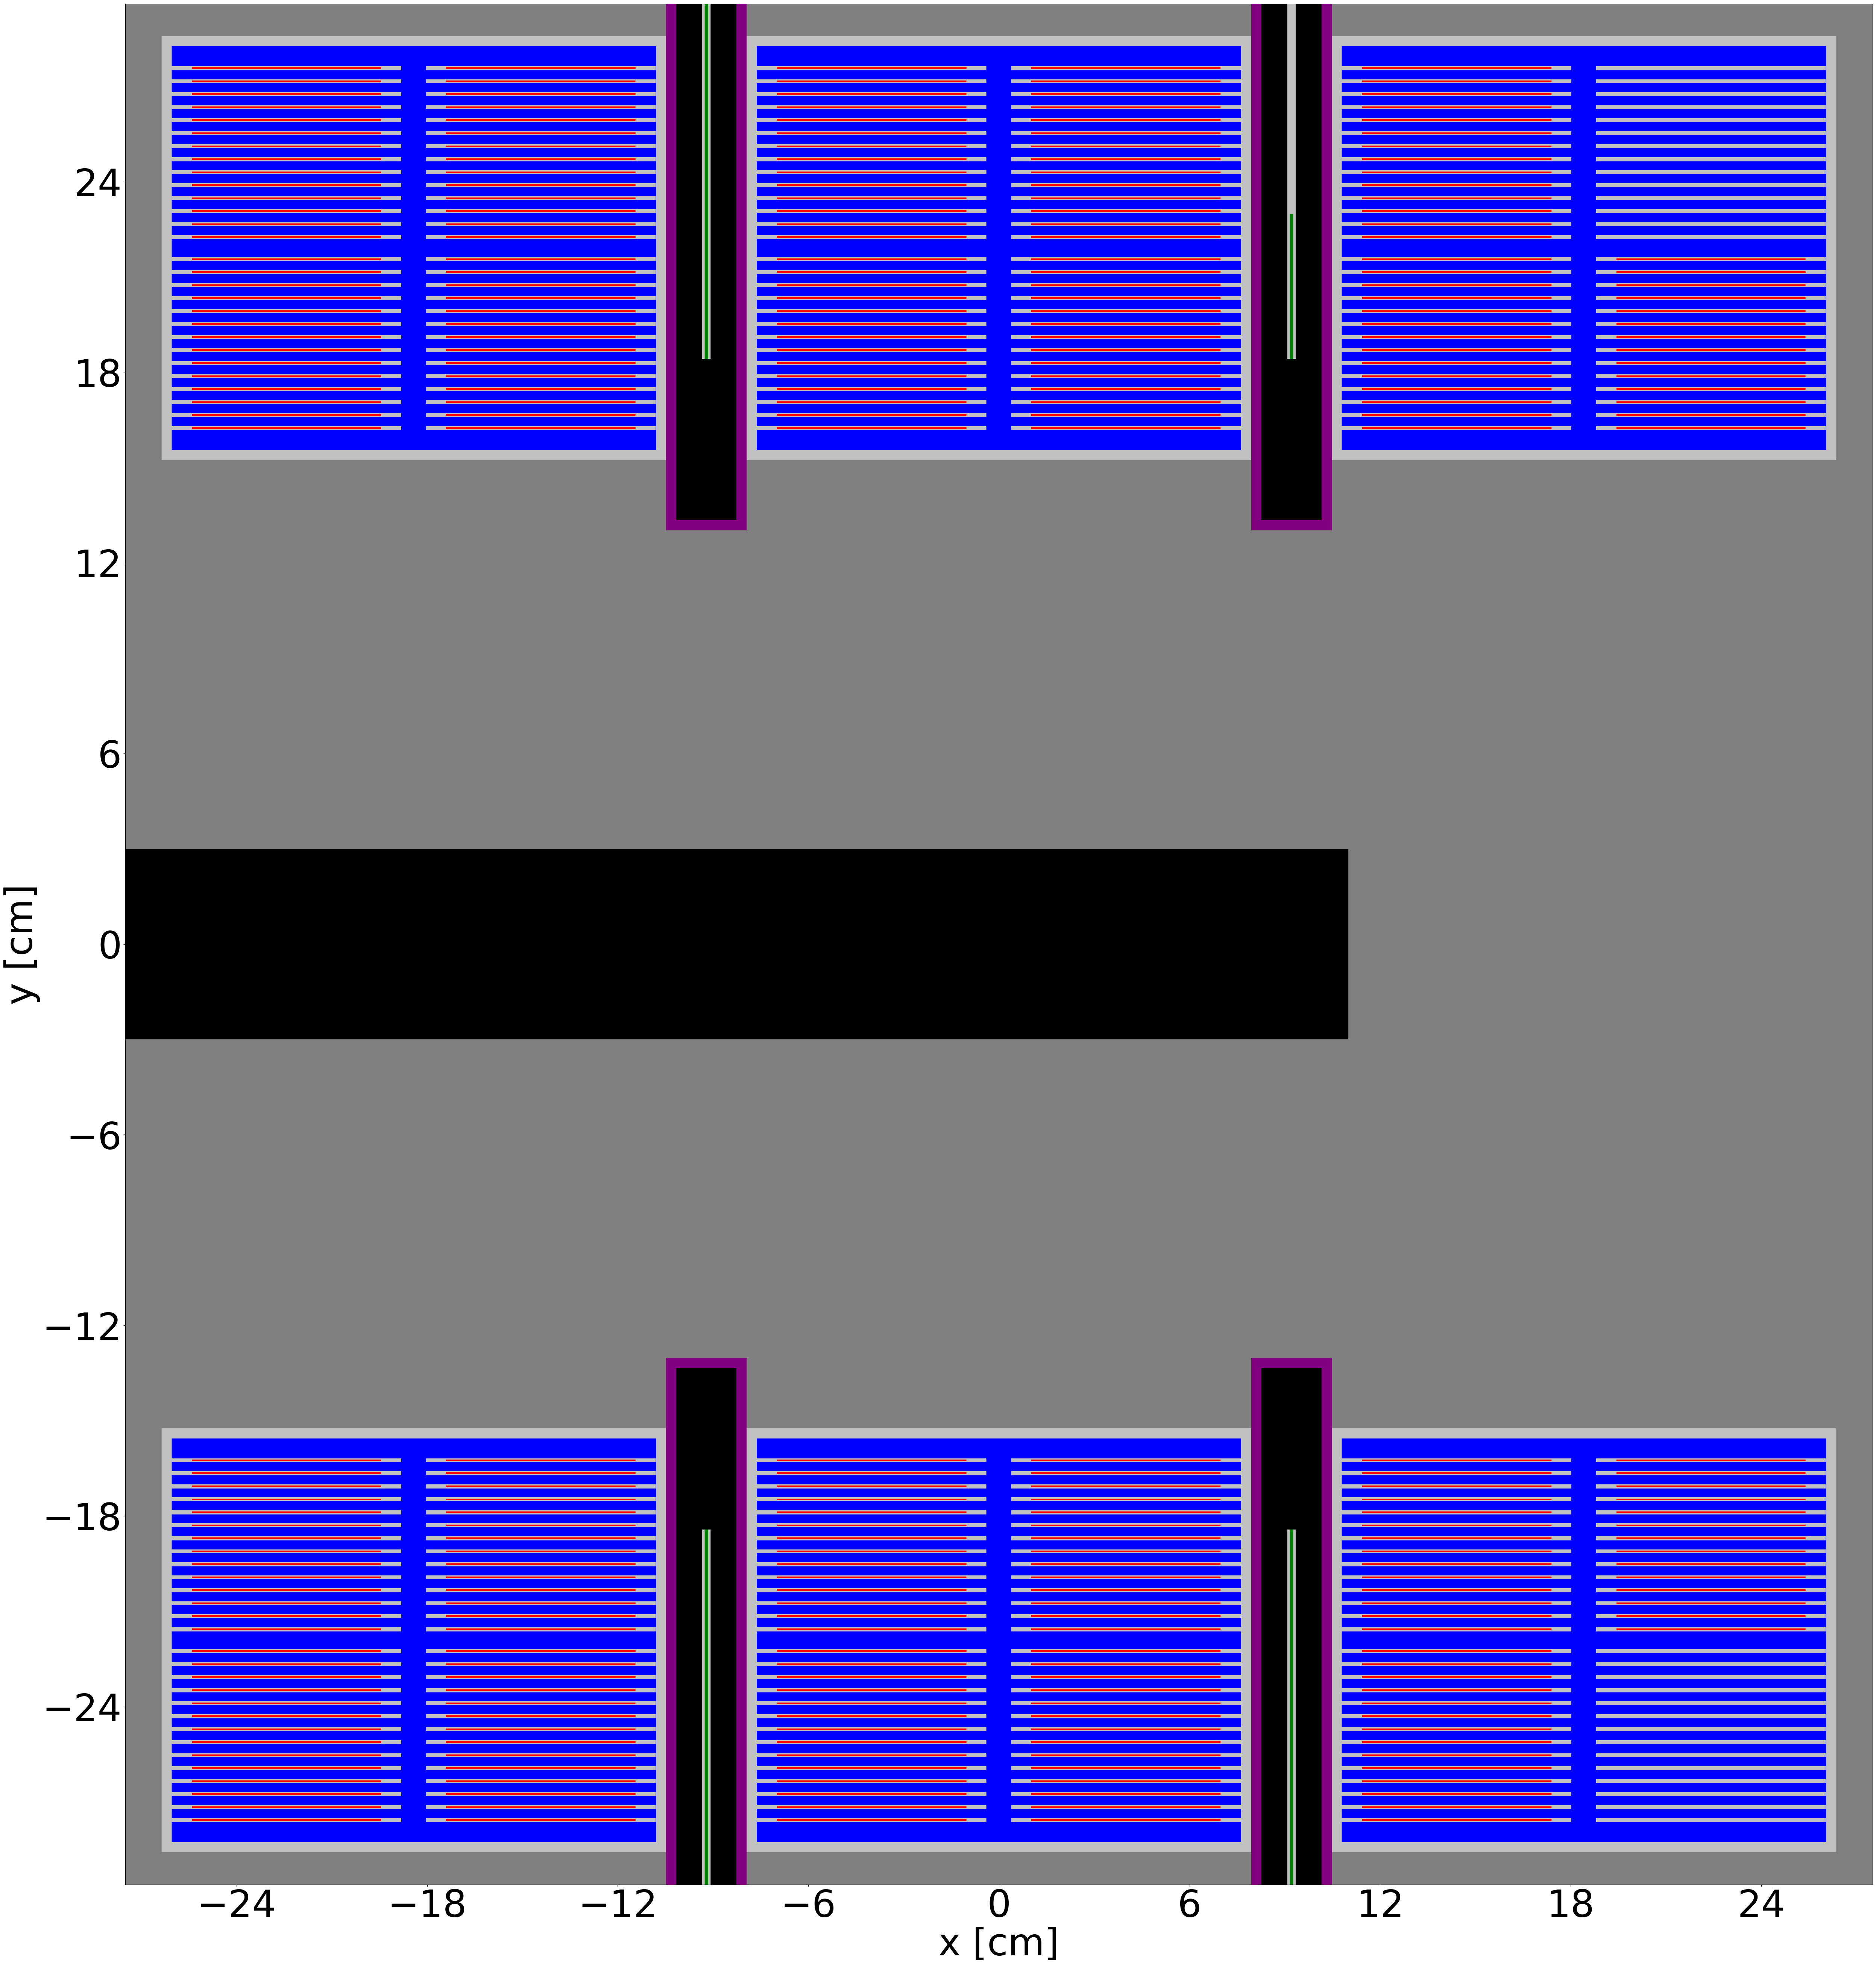

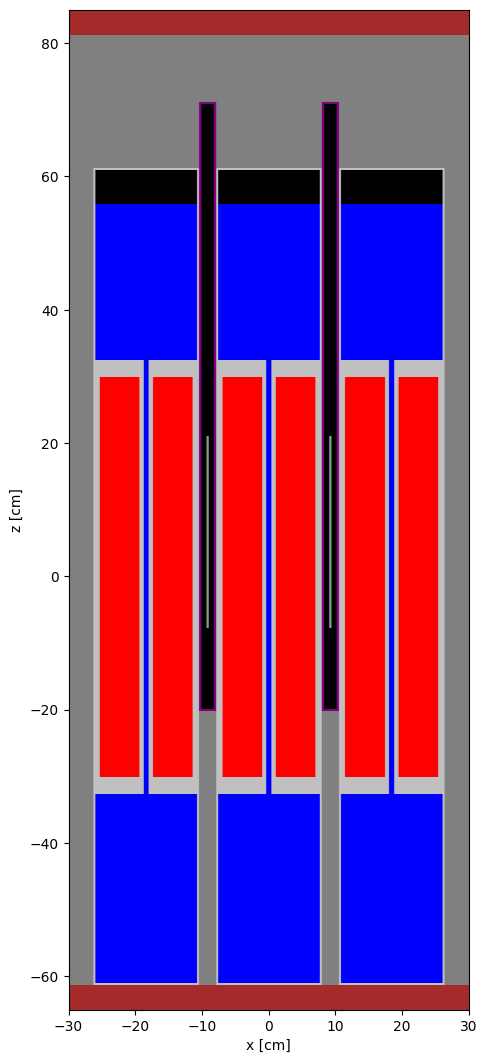

In [8]:
CORE_HEIGHT = 5*30.48
CORE_LENGTH = 5*30.48
CORE_WIDTH = 5*30.48


core_left = mc.XPlane(x0= -CORE_WIDTH/2)
core_right = mc.XPlane(x0= 264.16 - (CORE_WIDTH/2))
core_back = mc.YPlane(y0= -CORE_LENGTH/2)
core_front = mc.YPlane(y0= CORE_LENGTH/2)
core_bottom = bottom_box_outer_boundary
core_top = top_box_outer_boundary

thermal_column_cylinder_1 = mc.XCylinder(y0=0, z0=0, r= 10)
thermal_column_cylinder_2 = mc.XCylinder(y0=35, z0=0, r= 5)
thermal_column_cylinder_3 = mc.XCylinder(y0=-35, z0=0, r= 5)
thermal_column_right = mc.XPlane(x0= (BOX_Y_SPACING*(37/6)))
thermal_column_left = mc.XPlane(x0= CORE_WIDTH/2)

thermal_column_cell_1 = mc.Cell(fill=air, region= (-thermal_column_cylinder_1 &
                                                  -thermal_column_right & +thermal_column_left ))

core_region = (+core_left & -core_right & +core_back & -core_front & +core_bottom & -core_top &
               ~thermal_column_cell_1.region )

north_air_left = core_left
north_air_right = mc.XPlane(x0= CORE_WIDTH/2)
north_air_back = core_front
north_air_front = mc.YPlane(y0= (CORE_LENGTH/2) + 20.32)
north_air_bottom = core_bottom
north_air_top = core_top

north_air_region = (+north_air_left & -north_air_right & +north_air_back & -north_air_front &
                    +north_air_bottom & -north_air_top & ~safety_blade_3_cell.region & ~regulating_blade_cell.region)


south_air_left = core_left
south_air_right = north_air_right
south_air_back = mc.YPlane(y0= -(CORE_LENGTH/2) - 20.32)
south_air_front = core_back 
south_air_bottom = core_bottom
south_air_top = core_top

south_air_region = (+south_air_left & -south_air_right & +south_air_back & -south_air_front &
                    +south_air_bottom & -south_air_top & ~safety_blade_1_cell.region & ~safety_blade_2_cell.region)


core_air_cell = mc.Cell(fill=air, region= north_air_region | south_air_region)






central_vertical_port_cylinder = mc.ZCylinder(x0=0, y0=0, r=3)
west_vertical_port_cylinder = mc.ZCylinder(x0=-20, y0=0, r=3)
east_vertical_port_cylinder = mc.ZCylinder(x0=20, y0=0, r=3)
vertical_port_top = mc.ZPlane(z0= 60.95 + 0.318 + 25.4 + 152.4)
vertical_port_bottom = mc.ZPlane(z0= 50)

central_vertical_port_cell = mc.Cell(fill=air, region= (-central_vertical_port_cylinder &
                                                       -vertical_port_top & +vertical_port_bottom))

west_vertical_port_cell = mc.Cell(fill=air, region= (-west_vertical_port_cylinder &
                                                    -vertical_port_top & +vertical_port_bottom))
east_vertical_port_cell = mc.Cell(fill=air, region= (-east_vertical_port_cylinder & 
                                                    -vertical_port_top & +vertical_port_bottom))


rabit_tube_cylinder = mc.XCylinder(y0=0, z0=0, r= 3)
rabit_tube_right = mc.XPlane(x0= 11)
rabit_tube_left = mc.XPlane(x0= -(BOX_Y_SPACING*7.5) - 101.6)

rabit_tube_cell = mc.Cell(fill= air, region = -rabit_tube_cylinder & -rabit_tube_right & +rabit_tube_left)

graphite_cell_1 = mc.Cell(fill=graphite, region= (core_region & ~fuel_box_1_cell.region & ~fuel_box_2_cell.region &
                                                      ~fuel_box_3_cell.region & ~fuel_box_4_cell.region &
                                                      ~fuel_box_5_cell.region & ~fuel_box_6_cell.region &
                                                      ~safety_blade_1_cell.region & ~safety_blade_2_cell.region &
                                                      ~safety_blade_3_cell.region & ~regulating_blade_cell.region &
                                                      ~thermal_column_cell_1.region &  ~rabit_tube_cell.region &
                                                      ~west_vertical_port_cell.region &
                                                      ~east_vertical_port_cell.region &
                                                      ~central_vertical_port_cell.region))

extra_graphite_left = mc.XPlane(x0= -BOX_Y_SPACING*(4/3))
extra_graphite_right = mc.XPlane(x0= BOX_Y_SPACING*(4/3))
extra_graphite_back = mc.YPlane(y0= -BOX_Y_SPACING*(4/3))
extra_graphite_front = mc.YPlane(y0= BOX_Y_SPACING*(4/3))
extra_graphite_bottom = core_top
extra_graphite_top = mc.ZPlane(z0= 60.95 + 20.32)

graphite_cell_2 = mc.Cell(fill=graphite, region= (+extra_graphite_left & -extra_graphite_right &
                                                    +extra_graphite_back & -extra_graphite_front &
                                                    +extra_graphite_bottom & -extra_graphite_top &
                                                    ~thermal_column_cell_1.region  & ~rabit_tube_cell.region &
                                                    ~west_vertical_port_cell.region & ~east_vertical_port_cell.region &
                                                    ~central_vertical_port_cell.region & ~safety_blade_1_cell.region &
                                                  ~safety_blade_2_cell.region & ~safety_blade_3_cell.region &
                                                  ~regulating_blade_cell.region))

water_tank_right = core_left
water_tank_left = mc.XPlane(x0= -228.6)
water_tank_top = mc.ZPlane(z0= 350.52)
water_tank_bottom = core_bottom
water_tank_front = core_front
water_tank_back = core_back

water_tank_region = (-water_tank_right & + water_tank_left & - water_tank_top & 
                     + water_tank_bottom & - water_tank_front & + water_tank_back)

water_tank_cell = mc.Cell(fill=water, region= water_tank_region & ~ core_region & ~rabit_tube_cell.region)


concrete_top = vertical_port_top
concrete_bottom = mc.ZPlane(z0= -182.88)
concrete_right = mc.XPlane(x0= (BOX_Y_SPACING*(37/6)) + 101.6)
concrete_left = rabit_tube_left
concrete_front = mc.YPlane(y0= 279.4)
concrete_back = mc.YPlane(y0= -279.4)



concrete_region = -concrete_top & +concrete_bottom & -concrete_right & +concrete_left & -concrete_front & +concrete_back

concrete_filling = mc.Cell(fill=barite_concrete, region = (concrete_region & ~core_region &
                                                ~fuel_box_1_cell.region & ~fuel_box_2_cell.region &
                                                ~fuel_box_3_cell.region & ~fuel_box_4_cell.region &
                                                ~fuel_box_5_cell.region & ~fuel_box_6_cell.region &
                                                ~safety_blade_1_cell.region & ~safety_blade_2_cell.region &
                                                ~safety_blade_3_cell.region & ~regulating_blade_cell.region &
                                                ~graphite_cell_2.region & ~water_tank_region &
                                                ~core_air_cell.region &  ~thermal_column_cell_1.region &
                                                ~central_vertical_port_cell.region & ~west_vertical_port_cell.region &
                                                ~east_vertical_port_cell.region & ~rabit_tube_cell.region))





air_filling_cell = mc.Cell(fill=air, region = (~concrete_region & ~core_region &
                                                ~fuel_box_1_cell.region & ~fuel_box_2_cell.region &
                                                ~fuel_box_3_cell.region & ~fuel_box_4_cell.region &
                                                ~fuel_box_5_cell.region & ~fuel_box_6_cell.region &
                                                ~safety_blade_1_cell.region & ~safety_blade_2_cell.region &
                                                ~safety_blade_3_cell.region & ~regulating_blade_cell.region &
                                                ~graphite_cell_2.region & ~water_tank_region &
                                                ~core_air_cell.region &  ~thermal_column_cell_1.region &
                                                ~central_vertical_port_cell.region & ~west_vertical_port_cell.region &
                                                ~east_vertical_port_cell.region & ~rabit_tube_cell.region))




final_universe = mc.Universe(cells=[safety_blade_1_cell, safety_blade_2_cell, safety_blade_3_cell,
                                       regulating_blade_cell, fuel_box_1_cell, fuel_box_2_cell, fuel_box_3_cell,
                                       fuel_box_4_cell, fuel_box_5_cell, fuel_box_6_cell, graphite_cell_1,
                                       graphite_cell_2, concrete_filling, water_tank_cell, core_air_cell,
                                       thermal_column_cell_1,
                                       central_vertical_port_cell, west_vertical_port_cell,
                                       east_vertical_port_cell, rabit_tube_cell, air_filling_cell])





top = mc.ZPlane(z0= 400, boundary_type='vacuum')
bottom = mc.ZPlane(z0= -200, boundary_type='vacuum')
right = mc.XPlane(x0= 300, boundary_type='vacuum')
left = mc.XPlane(x0= -350, boundary_type='vacuum')
front = mc.YPlane(y0= 300, boundary_type='vacuum')
back = mc.YPlane(y0= -300, boundary_type='vacuum')

final_cell = mc.Cell(fill= final_universe, region= -top & +bottom & -right & +left & -front & +back)

root_universe = mc.Universe(cells=[final_cell])


root_universe.plot(width=(280, 210), basis='xy', pixels=(10000,10000),
                   colors=colors, color_by='material', origin=(50,0,0))

fig_1 = plt.gcf()  
ax = plt.gca()  
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))  
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
ax.tick_params(axis='both', labelsize=86)
ax.set_xlabel(ax.get_xlabel(), fontsize=86)
ax.set_ylabel(ax.get_ylabel(), fontsize=86)


root_universe.plot(width=(55, 59.2), basis='xy', pixels=(5000,5000),
                   colors=colors, color_by='material', origin=(0,0,0))

fig_2 = plt.gcf()  
ax = plt.gca()  
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))  
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
ax.tick_params(axis='both', labelsize=72)
ax.set_xlabel(ax.get_xlabel(), fontsize=72)
ax.set_ylabel(ax.get_ylabel(), fontsize=72)


root_universe.plot(width=(280, 150), basis='xz', pixels=(10000,10000),
                   colors=colors, color_by='material', origin=(50,-20.35,10))

fig_3 = plt.gcf()  
ax = plt.gca()  
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))  
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
ax.tick_params(axis='both', labelsize=86)
ax.set_xlabel(ax.get_xlabel(), fontsize=86)
ax.set_ylabel(ax.get_ylabel(), fontsize=86)


root_universe.plot(width=(60, 150), basis='xz', pixels=(1000,1000),
                   colors=colors, color_by='material', origin=(0,-20.35,10))
    
root_universe.plot(width=(200, 150), basis='yz', pixels=(10000,10000),
                   colors=colors, color_by='material', origin=(3,0,10))

fig_4 = plt.gcf()  
ax = plt.gca()  
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))  
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
ax.tick_params(axis='both', labelsize=86)
ax.set_xlabel(ax.get_xlabel(), fontsize=86)
ax.set_ylabel(ax.get_ylabel(), fontsize=86)


geometry = mc.Geometry(root_universe)
geometry.export_to_xml()

Now that it's time to assign settings, let's talk about converging to a fission source, shannon entropy, and overall final accuracy:

Converging to a fission source: Any Monte Carlo simulation starts by transporting neutrons in the system that was created and collecting data from the process, the more neutrons transported, the more accurate the estimation will be. But do these neutrons really represent realistic fission neutron? not at first, a guess is made where neutrons are emitted in a region fuel is known to exist, with an isotropic spacial distribution, and a Watt spectrum energy distribution, this assumption is close to reality but not quite there. The good thing about most Monte Carlo codes is that the system converges to a fission source eventually, which means that, the more neutrons transported, the more information we have about the system, as we have created fission neutrons sites, energy distributions, etc. So what should be done is to anticipate time to converge to a fission source, by assigning inactive batches; batches that will only help converge to a fission source and get to know the system, without taking any data to calculate the final eigenvalue or tallies.

Shannon entropy: To estimate when does the system converge fully to a fission source, shannon entropy should be calculated, it simply measures the fluctuations in the eigenvalue calculation, when it stabilizes, it means that we have converged to a fission source, below, it is seen that we converged to a fission source at approximately batch 20, but yet we had 20 batches, because there are already fluctuations due to the stochastic nature of Monte Carlo simulation, so it is not possible to actually pinpoint where we fully converged to a fission source, but it definitely took more than 20 batches, the only way to really pinpoint it is to have infinite number of particles, but overall, 100 batches is a very conservative and safe assumption.

Overall final accuracy: The current setting are 700 batches, 100 inactive batches, 500,000 particles per batch, it took my AMD Ryzen™ 9 8945HS processor approximately 3 hours to run using all 16 threads, and as shown below, it achieved around 6 pcm error.

The error follow a 1/sqrt(n) function, given n is the total number of active particles, which means that in order to reduce the error to half, you need to multiply the number of active particles by 4, so optimization has to be done with great care here, as 20-30 pcm is the sweet spot between time and accuracy, any accuracy ambition more than that will be computationally expensive, any accuracy sacrifice will make the results less reliable.

A model called fresh_core.XML should be saved within this folder, it can be called out without the need to write or paste this script, as it contains the necessary XML files within it, the settings however were a little different, to make it more convenient and less expensive computationally, it was saved at 700 batches, 100 inactive batches, and 10,000 particles per batch, it can be modified however with ease by opening the XML file and changing it manually then saving it

When wanting to calculate Delayed Neutron Fraction (Beff), all that needs to be done is two eigenvalue calculations, one normal eigenvalue calculation, and one excluding delayed neutrons, the subtraction of the two gives the delayed neutron fraction, the way to do that is from the command "settings.create_delayed_neutrons = False" that is commented out below, by default it is set at True, which means it takes into account both prompt and delayed neutrons, when set at False, it will only take into account prompt neutrons

In [55]:
settings = mc.Settings()
settings.run_mode = 'eigenvalue'

source = mc.Source()
source.space = mc.stats.Point((0.0, 22, 0.0))
source.angle = mc.stats.Isotropic()
settings.energy_mode = ('continuous-energy')
settings.source = source

entropy_mesh = openmc.RegularMesh()
entropy_mesh.lower_left = (-28.0, -29.01, -30.02)
entropy_mesh.upper_right = (28.0, 29.01, 30.02)
entropy_mesh.dimension = (10, 10, 10)

# settings.create_delayed_neutrons = False
settings.batches = 500
settings.inactive = 100
settings.particles = 500000
settings.entropy_mesh = entropy_mesh
settings.output = {'tallies': False, 'summary': False}

settings.export_to_xml()
'''
fresh_core_model = mc.Model(geometry=geometry, materials=materials, settings=settings)
fresh_core_model.export_to_xml()

fresh_core_model.run()
 '''


mc.run()

/home/eastdusty/OpenMC_NEW/lib/python3.12/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Depletion is quite tricky here, due to the random nature of operational history of most training and research reactor, but, given the burnup in kWh per year, the reactor was burned in two steps, one step from 2006 until 2022 at approximately 70,000 kWh total burnup, why ? because in 2022, 4 fuel plates were added, so the plan is to average the energy consumed in all these years to a constant power, the first step will be done in the cell below, the next step will be done in an intermediate script that was not included as the only purpose it serves is doing the burnup once again but adding the new 4 plates, and have a fuel two fuel profiles 

The first step is broken down into 3 steps as seen below, the decision to do so was due to an outage that lasted between 2008 and 2015

Overall these burnup assumptions visibly dropped the accuracy of the model, but the model is still very reliable

In [10]:
mc.config['cross_sections'] = '/home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/cross_sections.xml'

op = mc.deplete.CoupledOperator(fresh_core,'/home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/chain_endfb80.xml')

TIME = [608, 2311, 2648] # days
POWER = [969.6, 0, 888.7] # Watts

integrator = openmc.deplete.PredictorIntegrator(op, TIME, POWER, timestep_units='d')

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

          favor of the model.xml file.


 Reading U234 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/U234.h5
 Reading C12 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/C12.h5
 Reading C13 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/C13.h5
 Reading Fe54 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Fe54.h5
 Reading Fe56 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Fe56.h5
 Reading Fe57 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Fe57.h5
 Reading Fe58 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Fe58.h5
 Reading O16 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/O16.h5
 Reading O17 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/O17.h5
 Reading O18 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/O18.h5
 Reading N

 Reading Ba130 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba130.h5
  Reading Ba132 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba132.h5
  Reading Ba134 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba134.h5
  Reading Ba135 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba135.h5
  Reading Ba136 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba136.h5
  Reading Ba137 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba137.h5
  Reading Ba138 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba138.h5
  Reading S32 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/S32.h5
 Reading S33 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/S33.h5
 Reading S34 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/

 Reading Si31 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Si31.h5
 Reading Si32 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Si32.h5
 Reading P31 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/P31.h5
 Reading S35 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/S35.h5
 Reading Cl35 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cl35.h5
 Reading Cl36 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cl36.h5
 Reading Cl37 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cl37.h5
 Reading Ar37 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ar37.h5
 Reading Ar39 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ar39.h5
 Reading Ar41 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ar41.h5
 Rea

 Reading Se82 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Se82.h5
 Reading Br79 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Br79.h5
 Reading Br80 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Br80.h5
 Reading Br81 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Br81.h5
 Reading Kr78 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Kr78.h5
 Reading Kr79 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Kr79.h5
 Reading Kr80 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Kr80.h5
 Reading Kr81 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Kr81.h5
 Reading Kr82 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Kr82.h5
 Reading Kr83 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Kr83.h5


 Reading Nb94 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Nb94.h5
 Reading Nb95 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Nb95.h5
 Reading Mo92 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo92.h5
 Reading Mo93 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo93.h5


 Reading Mo94 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo94.h5
 Reading Mo95 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo95.h5
 Reading Mo96 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo96.h5
 Reading Mo97 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo97.h5
 Reading Mo98 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo98.h5
 Reading Mo99 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo99.h5
 Reading Mo100 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Mo100.h5
  Reading Tc98 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Tc98.h5


 Reading Tc99 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Tc99.h5
 Reading Ru96 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ru96.h5
 Reading Ru97 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ru97.h5
 Reading Ru98 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ru98.h5
 Reading Ru99 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ru99.h5
 Reading Ru100 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ru100.h5
  Reading Ru101 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ru101.h5
  Reading Ru102 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ru102.h5
  Reading Ru103 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ru103.h5
  Reading Ru104 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neu

          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Cd107 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cd107.h5
  Reading Cd109 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cd109.h5
  Reading Cd115_m1 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cd115_m1
 .h5
 Reading In113 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/In113.h5
  Reading In114 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/In114.h5
  Reading In115 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/In115.h5
  Reading Sn112 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sn112.h5
  Reading Sn113 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sn113.h5
  Reading Sn114 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sn114.h5
  Reading Sn115 from
 /home/eastdusty/openmc_env/share/data/endfb80

          1200K
          2500K


 Reading Sn124 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sn124.h5
  Reading Sn125 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sn125.h5
  Reading Sn126 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sn126.h5
  Reading Sb121 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sb121.h5
  Reading Sb122 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sb122.h5
  Reading Sb123 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sb123.h5
  Reading Sb124 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sb124.h5
  Reading Sb125 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sb125.h5
  Reading Sb126 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Sb126.h5
  Reading Te120 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-

          1200K
          2500K


 Reading Te121 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te121.h5
  Reading Te121_m1 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te121_m1
 .h5
 Reading Te122 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te122.h5
  Reading Te123 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te123.h5
  Reading Te124 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te124.h5
  Reading Te125 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te125.h5
  Reading Te126 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te126.h5
  Reading Te127_m1 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te127_m1
 .h5
 Reading Te128 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Te128.h5
  Reading Te129_m1 from
 /home/eastdusty/openmc_env/share/da

 Reading I132 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/I132.h5
 Reading I132_m1 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/I132_m1.
 h5
 Reading I133 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/I133.h5
 Reading I134 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/I134.h5
 Reading I135 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/I135.h5
 Reading Xe123 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Xe123.h5
  Reading Xe124 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Xe124.h5
  Reading Xe125 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Xe125.h5
  Reading Xe126 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Xe126.h5
  Reading Xe127 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-

          2500K


 Reading Xe134 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Xe134.h5
  Reading Xe135 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Xe135.h5
  Reading Xe136 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Xe136.h5
  Reading Cs133 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cs133.h5
  Reading Cs134 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cs134.h5
  Reading Cs135 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cs135.h5
  Reading Cs136 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cs136.h5
 

          1200K
          2500K


 Reading Cs137 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cs137.h5
  Reading Ba131 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba131.h5
  Reading Ba133 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba133.h5
  Reading Ba139 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba139.h5
  Reading Ba140 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ba140.h5
  Reading La138 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/La138.h5
  Reading La139 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/La139.h5
  Reading La140 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/La140.h5
  Reading Ce136 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ce136.h5
  Reading Ce137 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-

          1200K
          2500K


 Reading Eu157 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Eu157.h5
  Reading Gd152 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Gd152.h5
  Reading Gd153 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Gd153.h5
  Reading Gd154 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Gd154.h5
  Reading Gd155 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Gd155.h5
  Reading Gd156 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Gd156.h5
  Reading Gd157 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Gd157.h5
  Reading Gd158 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Gd158.h5
  Reading Gd159 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Gd159.h5
  Reading Gd160 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-

          1200K
          2500K


 Reading Yb169 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Yb169.h5
  Reading Yb170 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Yb170.h5
  Reading Yb171 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Yb171.h5
  Reading Yb172 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Yb172.h5
 

          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb173 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Yb173.h5
  Reading Yb174 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Yb174.h5
 

          1200K
          2500K
          1200K
          2500K


 Reading Yb175 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Yb175.h5
  Reading Yb176 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Yb176.h5
 

          1200K
          2500K


 Reading Lu175 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Lu175.h5
  Reading Lu176 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Lu176.h5
  Reading Hf174 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Hf174.h5
  Reading Hf175 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Hf175.h5
  Reading Hf176 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Hf176.h5
  Reading Hf177 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Hf177.h5
  Reading Hf178 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Hf178.h5
  Reading Hf179 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Hf179.h5
  Reading Hf180 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Hf180.h5
  Reading Hf181 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-

          1200K
          2500K
          1200K
          2500K


 Reading Ta180 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ta180.h5
  Reading Ta181 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ta181.h5
  Reading Ta182 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Ta182.h5
  Reading W180 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/W180.h5
 Reading W181 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/W181.h5
 Reading W182 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/W182.h5
 Reading W183 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/W183.h5
 Reading W184 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/W184.h5
 Reading W185 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/W185.h5
 Reading W186 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron

          1200K


 Reading Cf251 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cf251.h5
  Reading Cf252 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cf252.h5
  Reading Cf253 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cf253.h5
  Reading Cf254 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Cf254.h5
  Reading Es251 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Es251.h5
  Reading Es252 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Es252.h5
  Reading Es253 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Es253.h5
  Reading Es254 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Es254.h5
  Reading Es254_m1 from
 /home/eastdusty/openmc_env/share/data/endfb80/endfb-viii.0-hdf5/neutron/Es254_m1
 .h5
 Reading Es255 from
 /home/eastdusty/openmc_env/share/data/endfb80

The script below could be automated, but the approach that was followed was extracting the materials in the fuel and changing the fuel definition accordingly, but only important radionuclides should be taken into account, for example, a radionuclide that has a half life of minutes is really a waste of time to model, so a for actinides, fission products, and impurities, only a few radionuclides were chosen to be tracked. If it is desired to do more when it comes to depletion, the above depletion settings were ran with very good statistics and the file depletion_results_before_plates.h5 can be accessed and analyzed further

In [21]:

import numpy as np
from scipy import constants


results = openmc.deplete.Results(filename='depletion_results_before_plates.h5')

u232  =  results.get_atoms(mat=  fuel,  nuc='U232',  nuc_units='atom/cm3')
u233  =  results.get_atoms(mat=  fuel,  nuc='U233',  nuc_units='atom/cm3')
u234  =  results.get_atoms(mat=  fuel,  nuc='U234',  nuc_units='atom/cm3')
u235  =  results.get_atoms(mat=  fuel,  nuc='U235',  nuc_units='atom/cm3')
u236  =  results.get_atoms(mat=  fuel,  nuc='U236',  nuc_units='atom/cm3')
u237  =  results.get_atoms(mat=  fuel,  nuc='U237',  nuc_units='atom/cm3')
u238  =  results.get_atoms(mat=  fuel,  nuc='U238',  nuc_units='atom/cm3')
pa231 =  results.get_atoms(mat=  fuel,  nuc='Pa231', nuc_units='atom/cm3')
th232 =  results.get_atoms(mat=  fuel,  nuc='Th232', nuc_units='atom/cm3')
th231 =  results.get_atoms(mat=  fuel,  nuc='Th231', nuc_units='atom/cm3')
ac227 =  results.get_atoms(mat=  fuel,  nuc='Ac227', nuc_units='atom/cm3')
np237 =  results.get_atoms(mat=  fuel,  nuc='Np237', nuc_units='atom/cm3')
pu238 =  results.get_atoms(mat=  fuel,  nuc='Pu238', nuc_units='atom/cm3')
pu239 =  results.get_atoms(mat=  fuel,  nuc='Pu239', nuc_units='atom/cm3')
pu240 =  results.get_atoms(mat=  fuel,  nuc='Pu240', nuc_units='atom/cm3')
pu241 =  results.get_atoms(mat=  fuel,  nuc='Pu241', nuc_units='atom/cm3')
pu242 =  results.get_atoms(mat=  fuel,  nuc='Pu242', nuc_units='atom/cm3')
am241 =  results.get_atoms(mat=  fuel,  nuc='Am241', nuc_units='atom/cm3')
tc99  =  results.get_atoms(mat=  fuel,  nuc='Tc99',  nuc_units='atom/cm3')
i129  =  results.get_atoms(mat=  fuel,  nuc='I129',  nuc_units='atom/cm3')
cs135 =  results.get_atoms(mat=  fuel,  nuc='Cs135', nuc_units='atom/cm3')
zr93  =  results.get_atoms(mat=  fuel,  nuc='Zr93',  nuc_units='atom/cm3')
se79  =  results.get_atoms(mat=  fuel,  nuc='Se79',  nuc_units='atom/cm3')
ru106 =  results.get_atoms(mat=  fuel,  nuc='Ru106', nuc_units='atom/cm3')
pd107 =  results.get_atoms(mat=  fuel,  nuc='Pd107', nuc_units='atom/cm3')
si28  =  results.get_atoms(mat=  fuel,  nuc='Si28',  nuc_units='atom/cm3')
si29  =  results.get_atoms(mat=  fuel,  nuc='Si29',  nuc_units='atom/cm3')
si30  =  results.get_atoms(mat=  fuel,  nuc='Si30',  nuc_units='atom/cm3')
al27  =  results.get_atoms(mat=  fuel,  nuc='Al27',  nuc_units='atom/cm3')
c12   =  results.get_atoms(mat=  fuel,  nuc='C12',   nuc_units='atom/cm3')
c13   =  results.get_atoms(mat=  fuel,  nuc='C13',   nuc_units='atom/cm3')
fe54  =  results.get_atoms(mat=  fuel,  nuc='Fe54',  nuc_units='atom/cm3')
fe56  =  results.get_atoms(mat=  fuel,  nuc='Fe56',  nuc_units='atom/cm3')
fe57  =  results.get_atoms(mat=  fuel,  nuc='Fe57',  nuc_units='atom/cm3')
fe58  =  results.get_atoms(mat=  fuel,  nuc='Fe58',  nuc_units='atom/cm3')
o16   =  results.get_atoms(mat=  fuel,  nuc='O16',   nuc_units='atom/cm3')
o17   =  results.get_atoms(mat=  fuel,  nuc='O17',   nuc_units='atom/cm3')
o18   =  results.get_atoms(mat=  fuel,  nuc='O18',   nuc_units='atom/cm3')
n14   =  results.get_atoms(mat=  fuel,  nuc='N14',   nuc_units='atom/cm3')
n15   =  results.get_atoms(mat=  fuel,  nuc='N15',   nuc_units='atom/cm3')
cd106 =  results.get_atoms(mat=  cadmium,  nuc='Cd106', nuc_units='atom/cm3')
cd108 =  results.get_atoms(mat=  cadmium,  nuc='Cd108', nuc_units='atom/cm3')
cd110 =  results.get_atoms(mat=  cadmium,  nuc='Cd110', nuc_units='atom/cm3')
cd111 =  results.get_atoms(mat=  cadmium,  nuc='Cd111', nuc_units='atom/cm3')
cd112 =  results.get_atoms(mat=  cadmium,  nuc='Cd112', nuc_units='atom/cm3')
cd113 =  results.get_atoms(mat=  cadmium,  nuc='Cd113', nuc_units='atom/cm3')
cd114 =  results.get_atoms(mat=  cadmium,  nuc='Cd114', nuc_units='atom/cm3')
cd116 =  results.get_atoms(mat=  cadmium,  nuc='Cd116', nuc_units='atom/cm3')
in115 =  results.get_atoms(mat=  cadmium,  nuc='In115', nuc_units='atom/cm3')
in117 =  results.get_atoms(mat=  cadmium,  nuc='In117', nuc_units='atom/cm3')

total = (u232[1][3] +  u233[1][3] +  u234[1][3] +  u235[1][3] +  u236[1][3] +  u237[1][3] +  u238[1][3] +
        pa231[1][3] + th232[1][3] + th231[1][3] + ac227[1][3] + np237[1][3] + pu238[1][3] + pu239[1][3] +
        pu240[1][3] + pu241[1][3] + pu242[1][3] + am241[1][3] +  tc99[1][3] +  i129[1][3] + cs135[1][3] +
         zr93[1][3] +  se79[1][3] + ru106[1][3] + pd107[1][3] +  si28[1][3] +  si29[1][3] +  si30[1][3] +
         al27[1][3] +   c12[1][3] +   c13[1][3] +  fe54[1][3] +  fe56[1][3] +  fe57[1][3] +  fe58[1][3] +
          o16[1][3] +   o17[1][3] +   o18[1][3] +   n14[1][3] +   n15[1][3])
        
cd_total = (cd106[1][3] + cd108[1][3] + cd110[1][3] + cd111[1][3] + cd112[1][3] +
            cd113[1][3] + cd114[1][3] + cd116[1][3] + in115[1][3] + in117[1][3])

print(f'\nRelevant actinides:\n\nU-232 = {u232[1][3] / total}\nU-233 = {u233[1][3] / total}\nU-234 = {u234[1][3] / total}\n'
      f'U-235 = {u235[1][3] / total} \nU-236 = {u236[1][3] / total}\nU-237 = {u237[1][3] / total}' f'\n'
      f'U-238 = {u238[1][3] / total}\nPa-231 = {pa231[1][3] / total} \nTh-232 = {th232[1][3] / total}\n'
      f'Th-231 = {th231[1][3] / total}\nAc-227 = {ac227[1][3] / total}\nNp-237 = {np237[1][3] / total}\n'
      f'Pu-238 = {pu238[1][3] / total}' f'\nPu-239 = {pu239[1][3] / total}\nPu-240 = {pu240[1][3] / total}\n'
      f'Pu-241 = {pu241[1][3] / total}\nPu-242 = {pu242[1][3] / total}\nAm-241 = {am241[1][3] / total}' f'\n'
      f'\n\nRelevant fission products:\n\nTc-99 = {tc99[1][3] / total}\nI-129 = {i129[1][3] / total}\n'
      f'Cs-135 = {cs135[1][3] / total}' f'\nZr-93 = {zr93[1][3] / total}\nSe-79 = {se79[1][3] / total}\n'
      f'Ru-106 = {ru106[1][3] / total}\nPd-107 = {pd107[1][3] / total}' '\n\nSilicon and aluminum in U3Si2-Al\n\n'
      f'Si-28 = {si28[1][3] / total}\nSi-29 = {si29[1][3] / total}\nSi-30 = {si30[1][3] / total}\n\nAl-27 = {al27[1][3] / total}'
      '\n\nRelevant Impurities\n\n'
      f'C-12 = {c12[1][3] / total}\nC-13 = {c13[1][3] / total}\nFe-54 = {fe54[1][3] / total}\nFe-56 = {fe56[1][3] / total}\n'
      f'Fe-57 = {fe57[1][3] / total}\nFe-58 = {fe58[1][3] / total}\nO-16 = {o16[1][3] / total}\nO-17 = {o17[1][3] / total}\n'
      f'O-18 = {o18[1][3] / total}\nN-14 = {n14[1][3] / total}\nN-15 = {n15[1][3] / total}\n')

u235_enrichment_initial = u235[1][0] / (u232[1][0] + u233[1][0] + u234[1][0] + u235[1][0] + u236[1][0] + u237[1][0] + u238[1][0])

u235_enrichment = u235[1][3] / (u232[1][3] + u233[1][3] + u234[1][3] + u235[1][3] + u236[1][3] + u237[1][3] + u238[1][3])

print(f'Depletion of control blades\n\nCd-106 = {cd106[1][3] / cd_total}\nCd-108 = {cd108[1][3] / cd_total}\nCd-110 = {cd110[1][3] / cd_total}\n'
      f'Cd-111 = {cd111[1][3] / cd_total} \nCd-112 = {cd112[1][3] / cd_total} \nCd-113 = {cd113[1][3] / cd_total}\nCd-114 = {cd114[1][3] / cd_total}\nCd-116 = {cd116[1][3] / cd_total}\nIn-115 = {in115[1][3] / cd_total}\nIn-117 = {in117[1][3] / cd_total}')

u235 = results.get_atoms(mat=  fuel, nuc='U235', nuc_units='atoms')
pu239 = results.get_atoms(mat= fuel, nuc='Pu239', nuc_units='atoms')
pu241 = results.get_atoms(mat= fuel, nuc='Pu241', nuc_units='atoms')

u235_weight_0 = (u235[1][0] * 235.043928)/(constants.Avogadro)
u235_weight_1 = (u235[1][3] * 235.043928)/(constants.Avogadro)
pu239_weight_0 = (pu239[1][0] * 239.052162)/(constants.Avogadro)
pu239_weight_1 = (pu239[1][3] * 239.052162)/(constants.Avogadro)

print(f'\n\nInitial U-235 enrichment of fuel is {u235_enrichment_initial * 100:.4} at%')
print(f'\nCurrent U-235 enrichment of fuel is {u235_enrichment * 100:.4} at%')
cd_113_lost = cd113[1][3]/cd113[1][0]
print(f'\nRemaining fraction of Cd-113 is {cd_113_lost*100:.4} at%')

print(f'\nCurrent Pu239 buildup by weight is {pu239_weight_1 - pu239_weight_0:.6} grams')
print(f'\nCurrent U235 loss by weight is {u235_weight_0 - u235_weight_1:.6} grams')





Relevant actinides:

U-232 = 1.5825880043961049e-13
U-233 = 2.7267023584265513e-12
U-234 = 0.0004226319454118812
U-235 = 0.03186353362646211 
U-236 = 5.059105085556421e-06
U-237 = 1.3502121017954243e-11
U-238 = 0.1279479894284205
Pa-231 = 4.80713121443018e-10 
Th-232 = 1.4062172277931863e-11
Th-231 = 1.336647597477113e-13
Ac-227 = 6.619783620456893e-14
Np-237 = 4.404673615822699e-09
Pu-238 = 8.431995839454185e-13
Pu-239 = 2.2442313809853335e-06
Pu-240 = 7.451689657459889e-10
Pu-241 = 4.3249143109975734e-13
Pu-242 = 6.843182703859807e-17
Am-241 = 4.9134464267423745e-14


Relevant fission products:

Tc-99 = 1.6215772903232734e-06
I-129 = 1.4494727489491368e-07
Cs-135 = 1.7312734316714076e-06
Zr-93 = 1.6810304252260337e-06
Se-79 = 1.1837881587181212e-08
Ru-106 = 1.7434364901247982e-08
Pd-107 = 4.001309546585031e-08

Silicon and aluminum in U3Si2-Al

Si-28 = 0.08792436722140466
Si-29 = 0.004464557920279519
Si-30 = 0.0029430427035471818

Al-27 = 0.7297994085449636

Relevant Impurities

C-1